In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.externals import joblib
from sklearn.preprocessing import RobustScaler

In [2]:
scaler=RobustScaler()

In [3]:
#merging for BDT training
node_6=pd.read_hdf("node_6.hd5")
node_4=pd.read_hdf("node_4.hd5")
node_9=pd.read_hdf("node_9.hd5")
node_SM=pd.read_hdf("node_SM.hd5")


frames=[node_6,node_4,node_SM,node_9]
df=pd.concat(frames)


#ignoring category 0
df=df.loc[df.cat>0]
df.weight/=df.weight.mean()

#indexing
random_index = np.arange(df.shape[0]) 
np.random.shuffle(random_index)
df.loc[:,"random_index"]=random_index 
df.set_index("random_index",inplace=True)
df.sort_index(inplace=True)


In [4]:
features = ['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg']
features+=['leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta']
features+=['leadPho_pt','leadPho_eta','subleadPho_pt','subleadPho_eta']

In [5]:
#finding sum, count, mean of each category in weights column
df.groupby('cat')['weight'].agg(['sum','count','mean'])

,sum,count,mean
cat,,,
1,8441.220079,8433,1.000975
2,8076.923868,8202,0.984751
3,2708.455553,2788,0.971469
4,722.065735,750,0.962754
5,1607.524044,1523,1.055498
6,2891.527786,2868,1.008204
7,2198.774357,2245,0.979410
8,1026.545939,1077,0.953153
9,1551.757352,1446,1.073138


In [6]:
X = df[features]
y = df['cat'] 
w = df['weight']

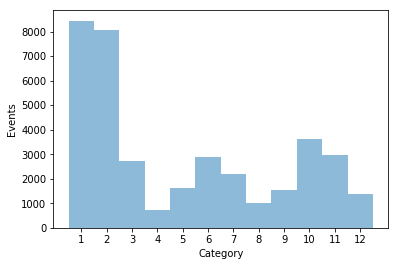

In [7]:
#plotting truth histogram
plt.figure(2)
bins=np.arange(0.5,13.5)
plt.hist(y,weights=w,bins=bins,alpha=0.5)
h=np.histogram(y,weights=w,bins=bins)
plt.ylabel('Events')
plt.xlabel('Category')
plt.xticks(np.arange(1,13))
plt.show()
plt.close()

In [17]:
#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#classifier fitted to training set 
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_4nodes.joblib') 

CPU times: user 9min 31s, sys: 5.29 s, total: 9min 36s
Wall time: 1min 12s


['clf_4nodes.joblib']

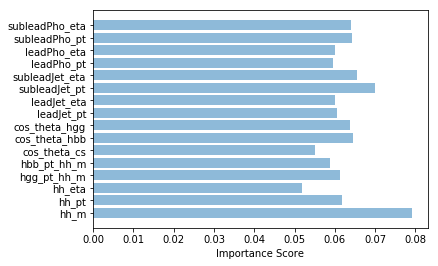

In [18]:
#features importance
clf=joblib.load('clf_4nodes.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [26]:
result=pd.read_hdf("optimisation_accu_9_4nodes.hd5")
print result[0:1]

result=pd.read_hdf("optimisation_cross_9_4nodes.hd5")
print result[0:1]

    learning_rate  max_depth  min_child_weight  n_estimators  reg_lambda  \
57            0.3         12               1.0          1000        10.0   

    subsample  accu_mean  accu_stdev  cross_mean  cross_stdev       ...        \
57        0.8   0.534309    0.006556    1.812224     0.035877       ...         

    cross_mean_6  cross_stdev_6  accu_mean_9  accu_stdev_9  cross_mean_9  \
57      1.408053       0.056388     0.350354      0.015937      3.573035   

    cross_stdev_9  accu_mean_SM  accu_stdev_SM  cross_mean_SM  cross_stdev_SM  
57       0.098913      0.738631       0.011183       1.013523        0.053918  

[1 rows x 26 columns]
    learning_rate  max_depth  min_child_weight  n_estimators  reg_lambda  \
28            0.1          3             100.0           300         0.1   

    subsample  accu_mean  accu_stdev  cross_mean  cross_stdev       ...        \
28        0.8   0.557176    0.004945    1.194956       0.0099       ...         

    cross_mean_6  cross_stdev_6 

In [18]:
#clf1-merged (cross and accu) and cross 9

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#classifier fitted to training set 
clf=XGBClassifier(learning_rate=0.1, reg_lambda= 0.1, subsample=0.8, max_depth=3, 
                  n_estimators=300, min_child_weight=100, n_jobs=8, objective='multi:softmax')
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf1_4nodes.joblib') 

CPU times: user 2min 13s, sys: 1.5 s, total: 2min 14s
Wall time: 16.9 s


['clf1_4nodes.joblib']

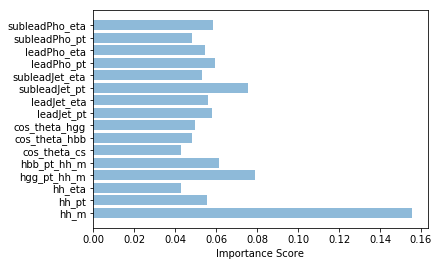

In [19]:
#features importance
clf=joblib.load('clf1_4nodes.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [20]:
#clf2- accu SM,6; cross SM,4,6

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#classifier fitted to training set 
clf=XGBClassifier(learning_rate=0.1, reg_lambda= 10, subsample=0.6, max_depth=10, 
                  n_estimators=1000, min_child_weight=0.2, n_jobs=8, objective='multi:softmax')
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf2_4nodes.joblib') 

CPU times: user 32min 35s, sys: 13.8 s, total: 32min 48s
Wall time: 4min 6s


['clf2_4nodes.joblib']

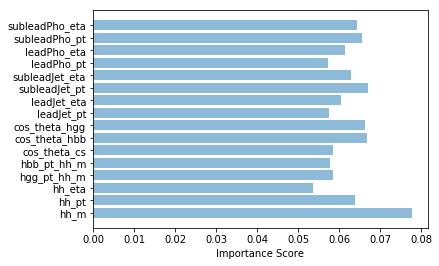

In [9]:
#features importance
clf=joblib.load('clf2_4nodes.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [8]:
#clf3- accu 4,9

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#classifier fitted to training set 
clf=XGBClassifier(learning_rate=0.3, reg_lambda= 10, subsample=0.8, max_depth=12, 
                  n_estimators=1000, min_child_weight=0.1, n_jobs=8, objective='multi:softmax')
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf3_4nodes.joblib') 

CPU times: user 37min 34s, sys: 17.5 s, total: 37min 51s
Wall time: 4min 44s


['clf3_4nodes.joblib']

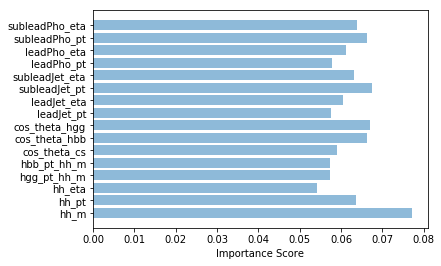

In [10]:
#features importance
clf=joblib.load('clf3_4nodes.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()